In [1]:
from chirho_diffeqpy import DiffEqPy, ATempParams
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.handlers import StaticBatchObservation, StaticIntervention, DynamicIntervention
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.observational.handlers import condition
from chirho.dynamical.ops import State
import numpy as np
import torch
from pyro import sample, set_rng_seed
from pyro.distributions import Uniform, Poisson
from typing import Tuple, Optional, Union, Callable
from functools import partial
from numbers import Real
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from contextlib import nullcontext
# The DiffEqPy backend interfaces with julia, so we must load a julia<>python interop backend.
import chirho_diffeqpy.lang_interop.julianumpy
from contextlib import ExitStack, nullcontext
from pyro.contrib.autoname import scope
# Global params are weird.
from functools import singledispatch, partial
import pyro
import torch
import zuko
from pyro.contrib.zuko import ZukoToPyro
from pyro.contrib.easyguide import easy_guide
from collections import namedtuple

pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(82901)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`


# System Definition

### Internal Stuff

This section employs effectful programming for easier hot-swapping of virtual fish dynamics and solver backends. It's not necessary to understand this code to understand the rest of the notebook.

In [2]:
# Effectful virtual fish function for easy hot-swapping.
class NoVirtualFish(NotImplementedError):
    pass

# noinspection PyProtectedMember
@pyro.poutine.runtime.effectful(type="virtual_fish_dynamics")
def virtual_fish_dynamics(state, atemp_params):
    raise NoVirtualFish()


class VirtualFishTrajectory(pyro.poutine.messenger.Messenger):
    def __init__(self, virtual_fish_dynamics_fn, initial_state, atemp_params):
        self.virtual_fish_dynamics_fn = virtual_fish_dynamics_fn
        self.initial_state = initial_state
        self.atemp_params = atemp_params
        super().__init__()

    def _pyro_virtual_fish_dynamics(self, msg: dict) -> None:
        msg["value"] = self.virtual_fish_dynamics_fn(*msg["args"], **msg["kwargs"])
        assert 'vfish_theta' in msg["value"]
        msg["done"] = True
    
    def _pyro_simulate(self, msg: dict) -> None:
        # Add the virtual fish parameters and starting state that are associated with the passed trajectory function.
        og_atemp_params = msg["kwargs"].pop("atemp_params")
        og_initial_state = msg["args"][1]
        
        atemp_params = dict(**og_atemp_params, **self.atemp_params)
        initial_state = dict(**og_initial_state, **self.initial_state)
        
        assert 'vfish_theta' in initial_state
        
        msg["kwargs"]["atemp_params"] = atemp_params
        msg["args"] = (msg["args"][0], initial_state, *msg["args"][2:])


# TorchDiffEq backend interoperation.
class PureTorchDiffEq(TorchDiffEq):

    # noinspection PyFinal
    def _pyro_simulate(self, msg: dict) -> None:
        atemp_params = msg["kwargs"].pop("atemp_params", None)
        dynamics = msg["args"][0]
        if atemp_params is None:
            raise ValueError("PureTorchDiffEq requires atemp_params to be passed into simulate as a keyword argument.")
        
        print("params", atemp_params)
        print("u0", msg["args"][1])

        closure_dynamics = partial(dynamics, atemp_params=atemp_params)
        msg["args"] = (closure_dynamics, *msg["args"][1:])

        return super()._pyro_simulate(msg)
    

@singledispatch
def sin(x):
    return np.sin(x)

@sin.register(torch.Tensor)
def _(x):
    return torch.sin(x)


@singledispatch
def cos(x):
    return np.cos(x)

@cos.register(torch.Tensor)
def _(x):
    return torch.cos(x)

In [3]:
# SOLVER = PureTorchDiffEq()
SOLVER = DiffEqPy()

### General, Multi-Fish System Dynamics

In [4]:
def pure_schooling_dynamics(state, atemp_params):
    thetas = state['thetas']
    
    # Compute the virtual fish dynamics and distance to real fish.
    try:
        # ...if the virtual fish is present.
        ddt_vfish = virtual_fish_dynamics(state, atemp_params)
        vfish_theta = state['vfish_theta']
        virtual_fish_diff = vfish_theta - thetas
    except NoVirtualFish:
        # ...otherwise proceed with no virtual fish.
        ddt_vfish = dict()
        virtual_fish_diff = 0.0
    
    # Compute the distances between the real fish and virtual fish.
    thetas_diff_mat = thetas[..., :, None] - thetas[..., None, :]
    thetas_diff_tots = thetas_diff_mat.sum(axis=-2) + virtual_fish_diff
    assert thetas.shape == thetas_diff_tots.shape
    
    # And the resulting dynamics.
    copy_coefs = atemp_params['copy_coefs']
    dthetas = thetas_diff_tots * copy_coefs
    
    return dict(
        thetas=dthetas,
        **ddt_vfish
    )

### Virtual Fish Definitions

In [5]:
def sinusoidal_virtual_fish(state, atemp_params):
    
    frequency = atemp_params['frequency']
    amplitude = atemp_params['amplitude']
    phase = atemp_params['phase']
    t = state['t']
    
    return dict(
        vfish_theta=amplitude * frequency * cos(frequency * t + phase)
    )

### Default Experiment Simulation

In [6]:
START_T = torch.tensor(0.0)
END_T = torch.tensor(5.0)
RES = 50
GET_TRUE_COPY_COEFS = lambda: torch.tensor([3., 1.])

def run_experiment(logging_times, initial_state, atemp_params):
    with LogTrajectory(times=logging_times) as logging_trajectory:
        simulate(
            pure_schooling_dynamics,
            initial_state,
            START_T,
            END_T,
            atemp_params=atemp_params
        )
    return logging_trajectory.trajectory

### Mesoscopic Observations

In [7]:
# def polarization_fn(theta):
#     theta = theta.T
#     assert theta.shape[-1] == 2, "Multi-fish polarization is not yet implemented!"
#     return torch.sqrt((1+torch.cos(theta[...,0]-theta[...,1]))/2)

def polarization_fn(theta):
    theta = theta.T
    assert theta.shape[-1] == 2, "Multi-fish polarization is not yet implemented!"
    
    # Use the cosine difference identity directly, which is naturally wraparound-aware
    return torch.sqrt((1 + torch.cos(theta[..., 0]) * torch.cos(theta[..., 1]) + torch.sin(theta[..., 0]) * torch.sin(theta[..., 1])) / 2)

In [8]:
# TODO add 3, 1/1, 3 non-identification example here

### Experimental Meta-Model
We can now construct a hierarchical meta-model that simulates multiple experiments, but assumes that the same copy coefficients are shared across the fish in each experiment.  

In [9]:
def copy_coefficient_prior(num_fish: int):
    return sample("copy_coefs", dist.Uniform(0., 10.).expand((num_fish,)).to_event(1))
    
OBS_NOISE = 0.0001

def experimental_meta_model(num_fish: int = 2, experimental_contexts: Tuple = ()):
    copy_coefs = copy_coefficient_prior(num_fish)
    
    fixed_initial_state = dict(
        thetas=torch.linspace(0., torch.pi, num_fish)
    )
    
    fixed_observation_times = torch.linspace(START_T, END_T, RES)
    
    observed_polarizations = []
    trajectories = []
    
    for i, experimental_context in enumerate(experimental_contexts):
        
        with SOLVER, scope(prefix=f"experiment{i}"), experimental_context:
            trajectory = run_experiment(
                logging_times=fixed_observation_times,
                initial_state=fixed_initial_state,
                atemp_params=dict(
                    copy_coefs=copy_coefs
                )
            )
            
            polarization = polarization_fn(trajectory['thetas'])
            # A trivial noise model over the polarization. This largely functions to relax the problem for inference.
            observed_polarization = pyro.sample("polarization", dist.Normal(polarization, OBS_NOISE).to_event(1))
            
            trajectories.append(trajectory)
            observed_polarizations.append(observed_polarization)
    
    return trajectories, observed_polarizations
    

### Simulation Example

In [10]:
# Default experimental context
no_vfish = nullcontext()

# Simple sinusoidal virtual fish.
exemplar_sinusoid_vfish = VirtualFishTrajectory(
    sinusoidal_virtual_fish,
    initial_state=dict(
        vfish_theta=torch.tensor(0.0)
    ),
    atemp_params=dict(
        frequency=torch.tensor(1.),
        amplitude=torch.tensor(torch.pi),
        phase=torch.tensor(0.)
    )
)

In [11]:
def plot_experiments(trajectories, observed_polarizations):
    
    for i, trajectory in enumerate(trajectories):
        plt.figure()
        plt.suptitle(f"Fish Thetas {i}")
        plt.plot(trajectory['thetas'].detach().numpy().T)
        if 'vfish_theta' in trajectory:
            plt.plot(trajectory['vfish_theta'].detach().numpy(), label='vfish_theta', linestyle="--")
        
    plt.figure()
    plt.suptitle("Polarizations")
    for i, polarization in enumerate(observed_polarizations):
        plt.plot(polarization.detach().numpy(), label=f"Experiment {i}")
    plt.legend()
    
    plt.show()

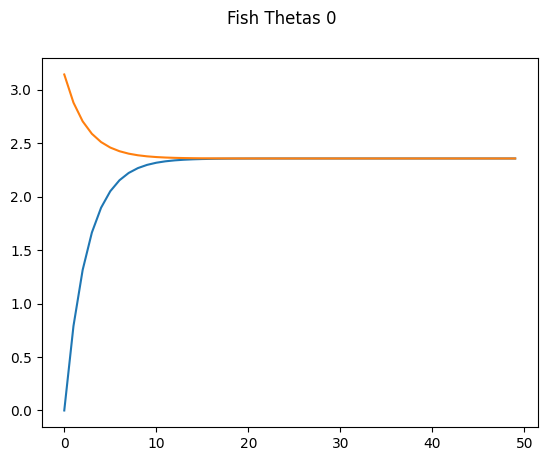

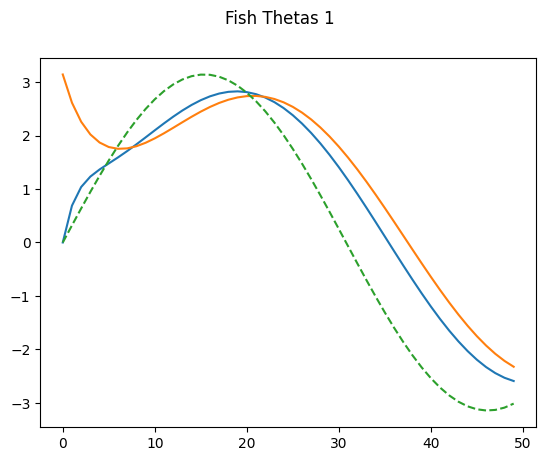

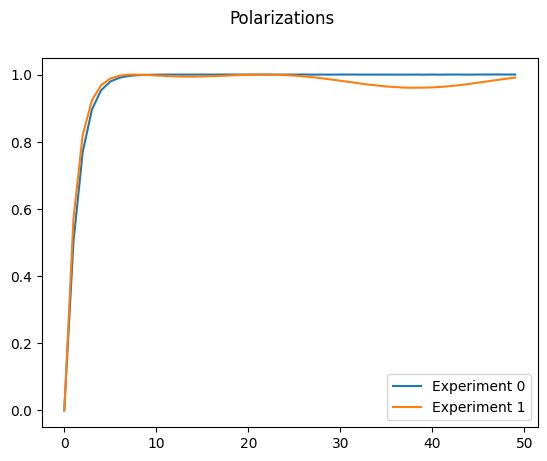

In [12]:
with condition(data=dict(copy_coefs=GET_TRUE_COPY_COEFS())):
    plot_experiments(
        *experimental_meta_model(
            num_fish=2, 
            experimental_contexts=(no_vfish, exemplar_sinusoid_vfish)
        )
    )

# Inference

### Inference Utilities

In [13]:
# A named tuple for build_svi to return.
SVI = namedtuple("SVI", ["svi_iter", "guide", "losses", "optim_ptr"])
STARTING_LR = 1e-3

def build_svi(prior, model, variational_family, *args, **kwargs):
    guide = variational_family(prior, *args, **kwargs)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    elbo()  # initialize parameters.
    params = list(elbo.parameters())
    optim_ptr = [torch.optim.Adam(params, lr=STARTING_LR), params]
    losses = []
    
    def svi_iter():
        optim, _ = optim_ptr
        optim.zero_grad()
        loss = elbo()
        loss.backward()
        optim.step()
        
        losses.append(loss.detach().item())
    
    return SVI(svi_iter, guide, losses, optim_ptr)


def change_lr_(svi: SVI, lr):
    _, params = svi.optim_ptr
    optim = torch.optim.Adam(params, lr=lr)
    svi.optim_ptr[0] = optim
    

def build_zuko_guide(model, num_latents):
    flow = zuko.flows.NSF(features=num_latents, context=0, transforms=1, hidden_features=(32, 32))
    flow.transform = flow.transform.inv  # inverse autoregressive flow (IAF) are fast to sample from

    @easy_guide(model)
    def zuko_guide(self):
        # Match everything cz we're going to sample them as a joint normalizing flow.
        group = self.group(match=".*")

        return group.sample("joint_nf", ZukoToPyro(flow()))[-1]

    zuko_guide._parameters = dict(flow.named_parameters())

    return zuko_guide

### Inference on Each Experiment, Separately and Together

In [14]:
# Generate the experimental data under parameter ground truth.
NUM_FISH = 2

with condition(data=dict(copy_coefs=GET_TRUE_COPY_COEFS())):
    _, (polar_no_vfish, polar_sin_vfish) = experimental_meta_model(
        num_fish=NUM_FISH, 
        experimental_contexts=(no_vfish, exemplar_sinusoid_vfish)
    )

In [15]:
prior_fixed_fish = partial(copy_coefficient_prior, num_fish=NUM_FISH)
# Standard experiment.
svi_no_vfish = build_svi(
    prior=prior_fixed_fish,
    model=condition(
        partial(experimental_meta_model, num_fish=NUM_FISH, experimental_contexts=(no_vfish,)),
        data={"experiment0/polarization": polar_no_vfish}
    ),
    variational_family=build_zuko_guide,
    num_latents=NUM_FISH
)

# Experiment with virtual fish.
svi_sin_vfish = build_svi(
    prior=prior_fixed_fish,
    model=condition(
        partial(experimental_meta_model, num_fish=NUM_FISH, experimental_contexts=(exemplar_sinusoid_vfish,)),
        data={"experiment0/polarization": polar_sin_vfish}
    ),
    variational_family=build_zuko_guide,
    num_latents=NUM_FISH
)

# All three experiments.
svi_all = build_svi(
    prior=prior_fixed_fish,
    model=condition(
        partial(experimental_meta_model, num_fish=NUM_FISH, experimental_contexts=(no_vfish, exemplar_sinusoid_vfish)),
        data={
            "experiment0/polarization": polar_no_vfish,
            "experiment1/polarization": polar_sin_vfish,
        }
    ),
    variational_family=build_zuko_guide,
    num_latents=NUM_FISH
)

svis = svi_no_vfish, svi_sin_vfish, svi_all

In [16]:
# Run the SVI iterations.
NUM_SVI_ITERS = 2000
for i in range(NUM_SVI_ITERS):
    [svi.svi_iter() for svi in svis]
    print(f"Progress {i+1}/{NUM_SVI_ITERS}", end="\r")
    
    if i == NUM_SVI_ITERS - NUM_SVI_ITERS // 4:
        lr = STARTING_LR / 10
        [change_lr_(svi, lr) for svi in svis]

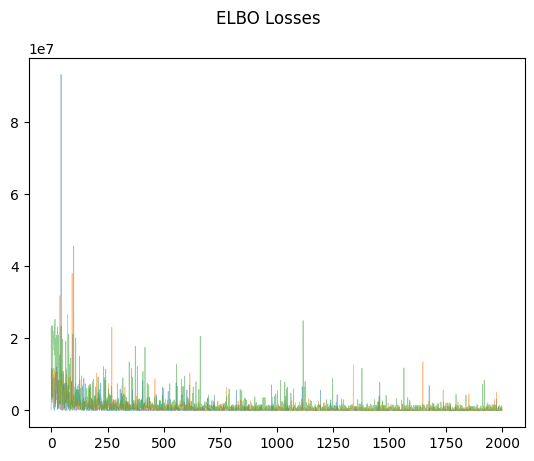

In [17]:
def plot_losses(*svis):
    plt.figure()
    plt.suptitle("ELBO Losses")
    for svi in svis:
        plt.plot(svi.losses, linewidth=0.5, alpha=0.5)
    
plot_losses(svi_no_vfish, svi_sin_vfish, svi_all)

In [18]:
def plot_posterior_samples_from_multiple_runs(true_params, num_samples, *guides, labels=None):
    
    post_samples = []
    for guide in guides:
        with pyro.plate("samples", num_samples):
            post_samples.append(guide())
            
    if labels is None:
        labels = [f"Inference {i}" for i in range(len(guides))]
    
    fig, ax = plt.subplots()
    for post_sample, lbl in zip(post_samples, labels):
        ax.scatter(post_sample['copy_coefs'][:,0].detach(), post_sample['copy_coefs'][:,1].detach(), s=0.2, alpha=0.5, label=lbl)
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$\beta$")
    # 0, 4 xlim ylim
    ax.set_xlim(0, 7)
    ax.set_ylim(0, 7)
    # Plot crosshairs at true_params
    ax.axvline(true_params['copy_coefs'][0].item(), color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.axhline(true_params['copy_coefs'][1].item(), color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.legend()
    return fig, ax

Ellipsis

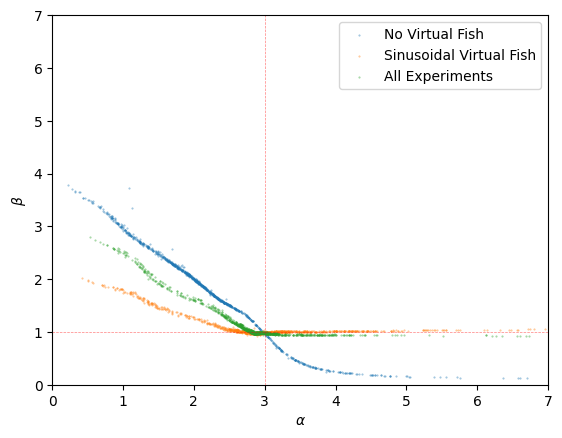

In [19]:
plot_posterior_samples_from_multiple_runs(
    dict(copy_coefs=GET_TRUE_COPY_COEFS()),
    1000,
    svi_no_vfish.guide,
    svi_sin_vfish.guide,
    svi_all.guide,
    labels=["No Virtual Fish", "Sinusoidal Virtual Fish", "All Experiments"]
)
...